Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import t
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [4]:
# preenchendo dados faltantes
df.tempo_emprego.fillna(df.tempo_emprego.mean(), inplace = True)

# Separando base de treino e teste
df2 = df.set_index('data_ref')
df2.drop('index', axis = 1, inplace = True)

X_train = df2.loc['2015-01-01':'2015-12-01'].copy()
y_test = df2.loc['2016-01-01':].copy()

X_train.reset_index(inplace=True)
y_test.reset_index(inplace=True)

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
df.describe()

,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,7.500000e+05
mean,8319.272793,0.433251,43.804733,7.748574,2.212241,2.323854e+04
std,4809.281774,0.739379,11.229868,6.100107,0.903428,7.910601e+04
min,0.000000,0.000000,22.000000,0.117808,1.000000,1.076700e+02
25%,4147.000000,0.000000,34.000000,3.635616,2.000000,3.467700e+03
50%,8324.000000,0.000000,43.000000,7.473973,2.000000,7.861820e+03
75%,12487.000000,1.000000,53.000000,9.090411,3.000000,1.831828e+04
max,16649.000000,14.000000,68.000000,42.906849,15.000000,4.083986e+06


In [6]:
df['mes'] = df['data_ref'].dt.month
df.groupby('mes')[['qtd_filhos',  'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda']].describe()

qtd_filhos                                                  idade  \
         count     mean       std  min  25%  50%  75%   max     count   
mes                                                                     
1     100000.0  0.43442  0.742351  0.0  0.0  0.0  1.0  14.0  100000.0   
2     100000.0  0.43468  0.748251  0.0  0.0  0.0  1.0  14.0  100000.0   
3     100000.0  0.43588  0.737966  0.0  0.0  0.0  1.0  14.0  100000.0   
4      50000.0  0.43120  0.725367  0.0  0.0  0.0  1.0  14.0   50000.0   
5      50000.0  0.43922  0.742750  0.0  0.0  0.0  1.0  14.0   50000.0   
6      50000.0  0.43168  0.735189  0.0  0.0  0.0  1.0  14.0   50000.0   
7      50000.0  0.42516  0.730048  0.0  0.0  0.0  1.0  14.0   50000.0   
8      50000.0  0.43184  0.739003  0.0  0.0  0.0  1.0  14.0   50000.0   
9      50000.0  0.43170  0.729648  0.0  0.0  0.0  1.0  14.0   50000.0   
10     50000.0  0.43130  0.736214  0.0  0.0  0.0  1.0  14.0   50000.0   
11     50000.0  0.43502  0.756300  0.0  0.0  0.0  1.0  14.0   50000.0   
12     50000.0  0.43168  0.738419  0.0  0.0  0.0  1.0  14.0   50000.0   

               ... qt_pessoas_residencia           renda                \
         mean  ...                   75%   max     count          mean   
mes            ...                                                       
1    43.81001  ...                   3.0  15.0  100000.0   8874.694651   
2    43.88400  ...                   3.0  15.0  100000.0   9579.923850   
3    43.75352  ...                   3.0  15.0  100000.0  11529.632597   
4    43.75040  ...                   3.0  15.0   50000.0  25028.580353   
5    43.85500  ...                   3.0  15.0   50000.0  35491.513447   
6    43.75634  ...                   3.0  15.0   50000.0  45040.693671   
7    43.90782  ...                   3.0  15.0   50000.0  49761.173706   
8    43.81874  ...                   3.0  15.0   50000.0  45283.725846   
9    43.82176  ...                   3.0  15.0   50000.0  35178.363626   
10   43.72236  ...                   3.0  15.0   50000.0  24156.071043   
11   43.74718  ...                   3.0  15.0   50000.0  16751.826980   
12   43.79634  ...                   3.0  15.0   50000.0  11917.720339   

                                                                          
               std     min        25%        50%         75%         max  
mes                                                                       
1     25329.039904  159.59   1976.420   3638.265   7181.2825   732561.26  
2     28720.806615  127.04   2004.570   3769.085   7618.9200   984315.37  
3     37663.069497  107.67   2024.170   4204.290   9149.5300  1401457.78  
4     71534.179791  446.18   5576.850  10225.115  19853.0700  2048088.01  
5    101391.950475  632.73   7834.645  14247.370  28118.1675  2904421.91  
6    124892.504293  812.26  10138.380  18403.470  36371.3300  3728517.03  
7    138692.524662  889.70  11021.005  20210.860  39842.6500  4083986.22  
8    130232.945285  812.26  10097.920  18462.160  36130.9800  3728517.03  
9    100846.083771  632.73   7780.490  14178.920  28135.5775  2904421.91  
10    64697.271395  446.18   5524.940  10108.290  19921.4400  2048088.01  
11    47203.794585  305.31   3763.470   6861.510  13549.5000  1401457.78  
12    33626.385857  214.43   2648.515   4861.720   9465.0625   984315.37  

[12 rows x 40 columns]

Text(0.5, 1.0, 'Número de linhas para cada mês da base de treino')

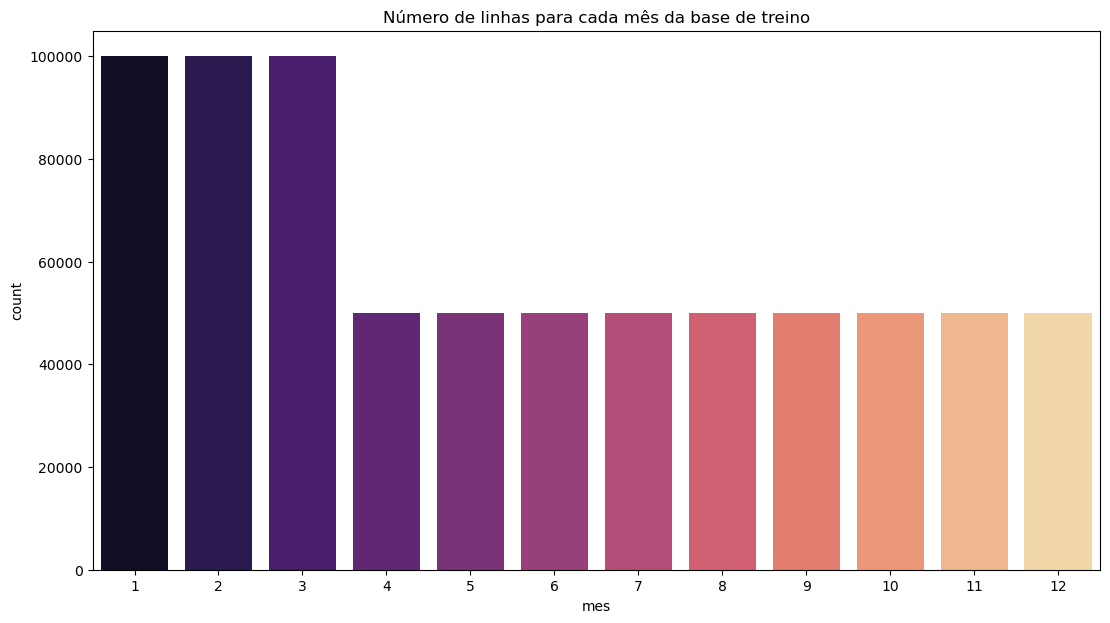

In [7]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.countplot(data=df, x='mes', palette='magma', ax=ax)
ax.set_title('Número de linhas para cada mês da base de treino')

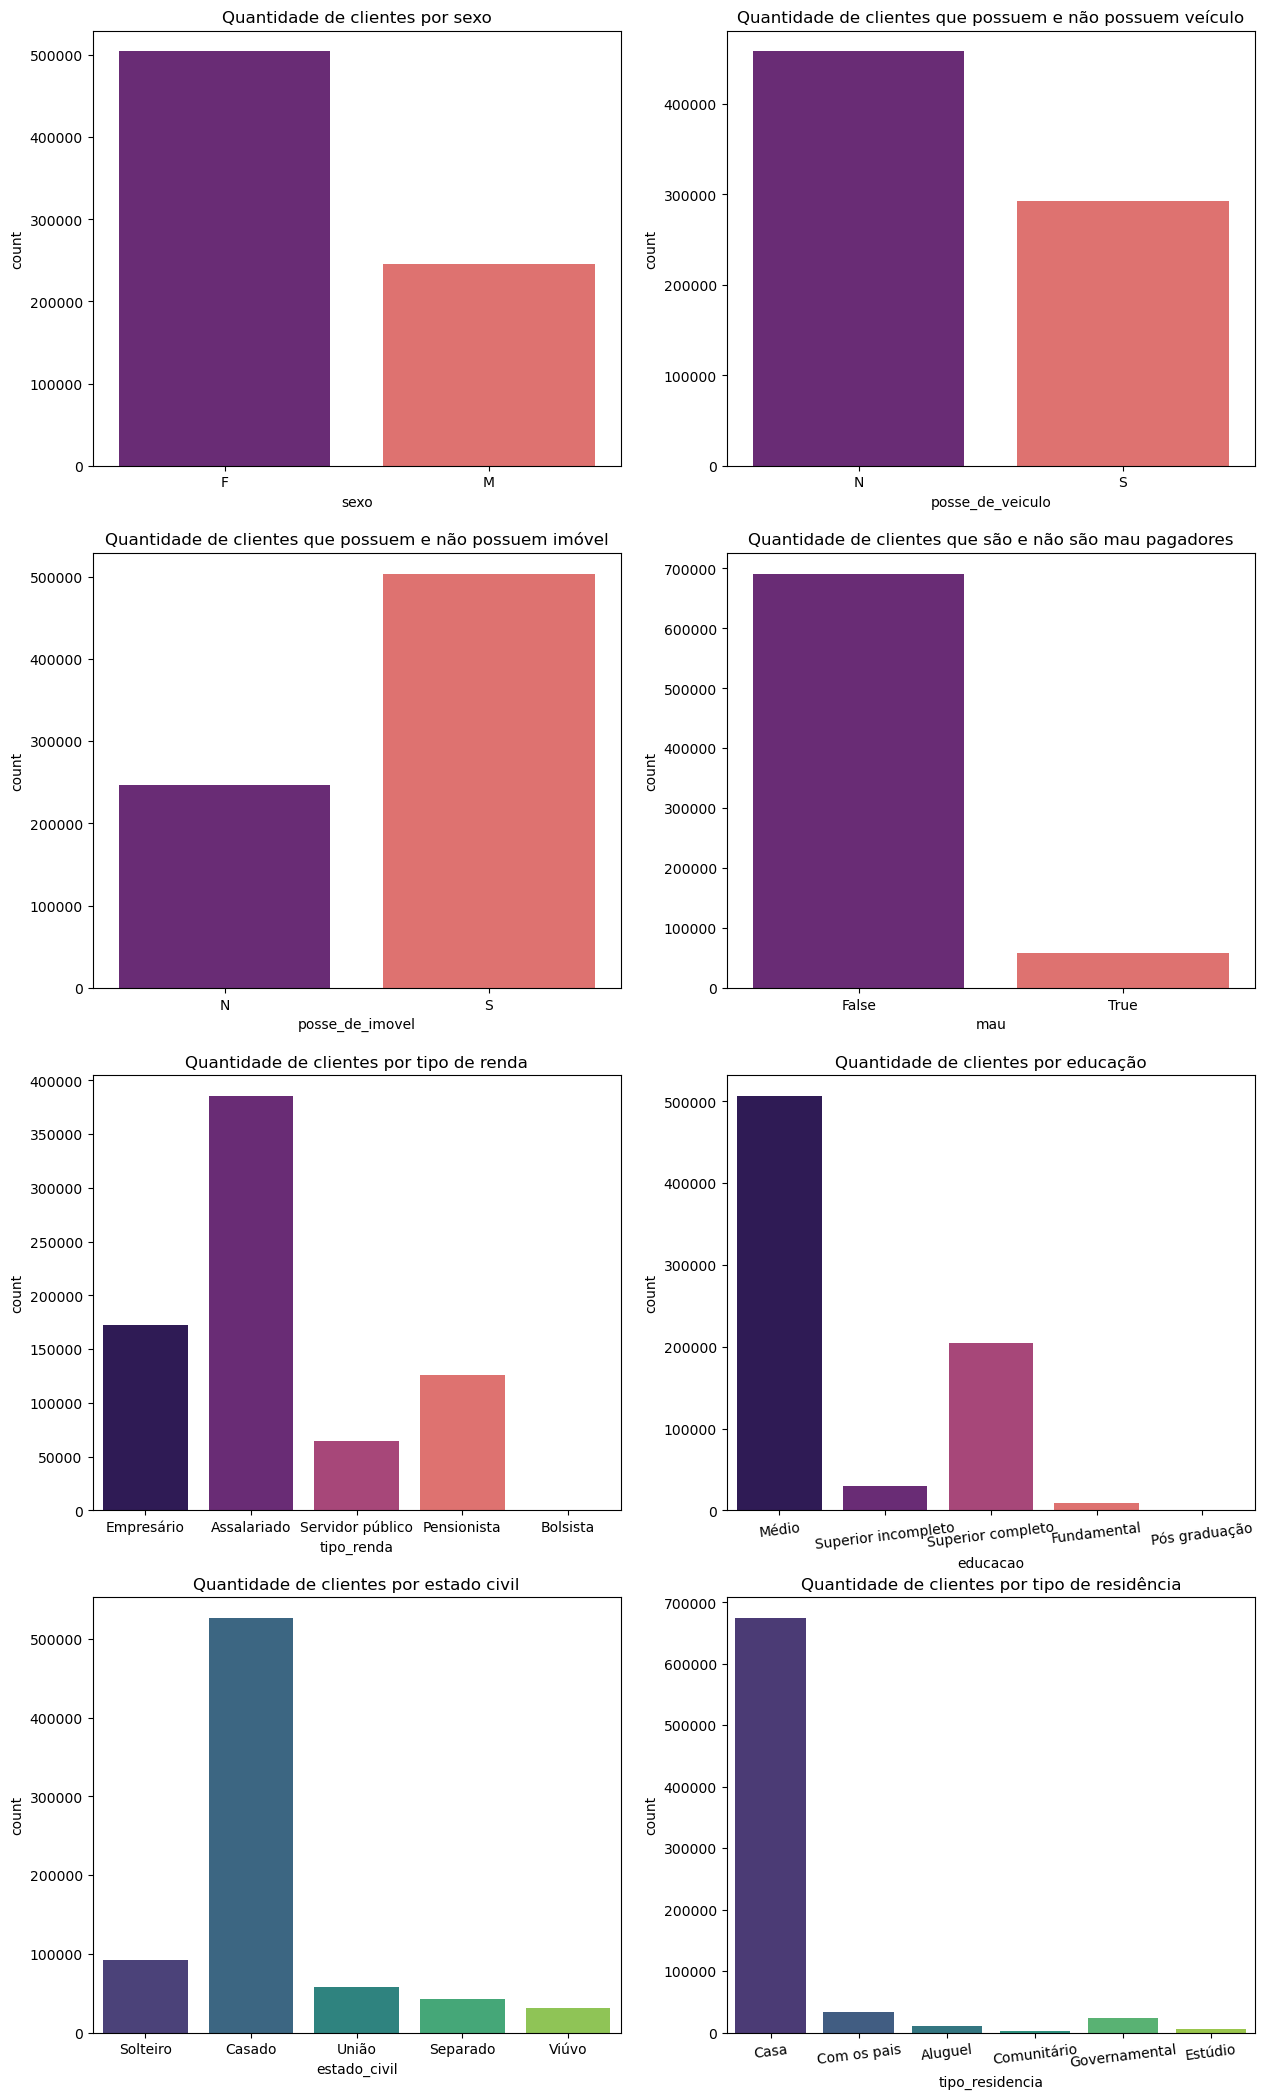

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 26))

sns.countplot(data=df, x='sexo', palette='magma', ax=ax[0, 0])
ax[0, 0].set_title('Quantidade de clientes por sexo')

sns.countplot(data=df, x='posse_de_veiculo', palette='magma', ax=ax[0, 1])
ax[0, 1].set_title('Quantidade de clientes que possuem e não possuem veículo')

sns.countplot(data=df, x='posse_de_imovel', palette='magma', ax=ax[1, 0])
ax[1, 0].set_title('Quantidade de clientes que possuem e não possuem imóvel')

sns.countplot(data=df, x='mau', palette='magma', ax=ax[1, 1])
ax[1, 1].set_title('Quantidade de clientes que são e não são mau pagadores')

sns.countplot(data=df, x='tipo_renda', palette='magma', ax=ax[2, 0])
ax[2, 0].set_title('Quantidade de clientes por tipo de renda')

sns.countplot(data=df, x='educacao', palette='magma', ax=ax[2, 1])
ax[2, 1].set_title('Quantidade de clientes por educação')
for tick in ax[2, 1].get_xticklabels():
    tick.set_rotation(7)

sns.countplot(data=df, x='estado_civil', palette='viridis', ax=ax[3, 0])
ax[3, 0].set_title('Quantidade de clientes por estado civil')

sns.countplot(data=df, x='tipo_residencia', palette='viridis', ax=ax[3, 1])
ax[3, 1].set_title('Quantidade de clientes por tipo de residência')

for tick in ax[3, 1].get_xticklabels():
    tick.set_rotation(7)

Text(0.5, 1.0, 'Quantidade de clientes por renda')

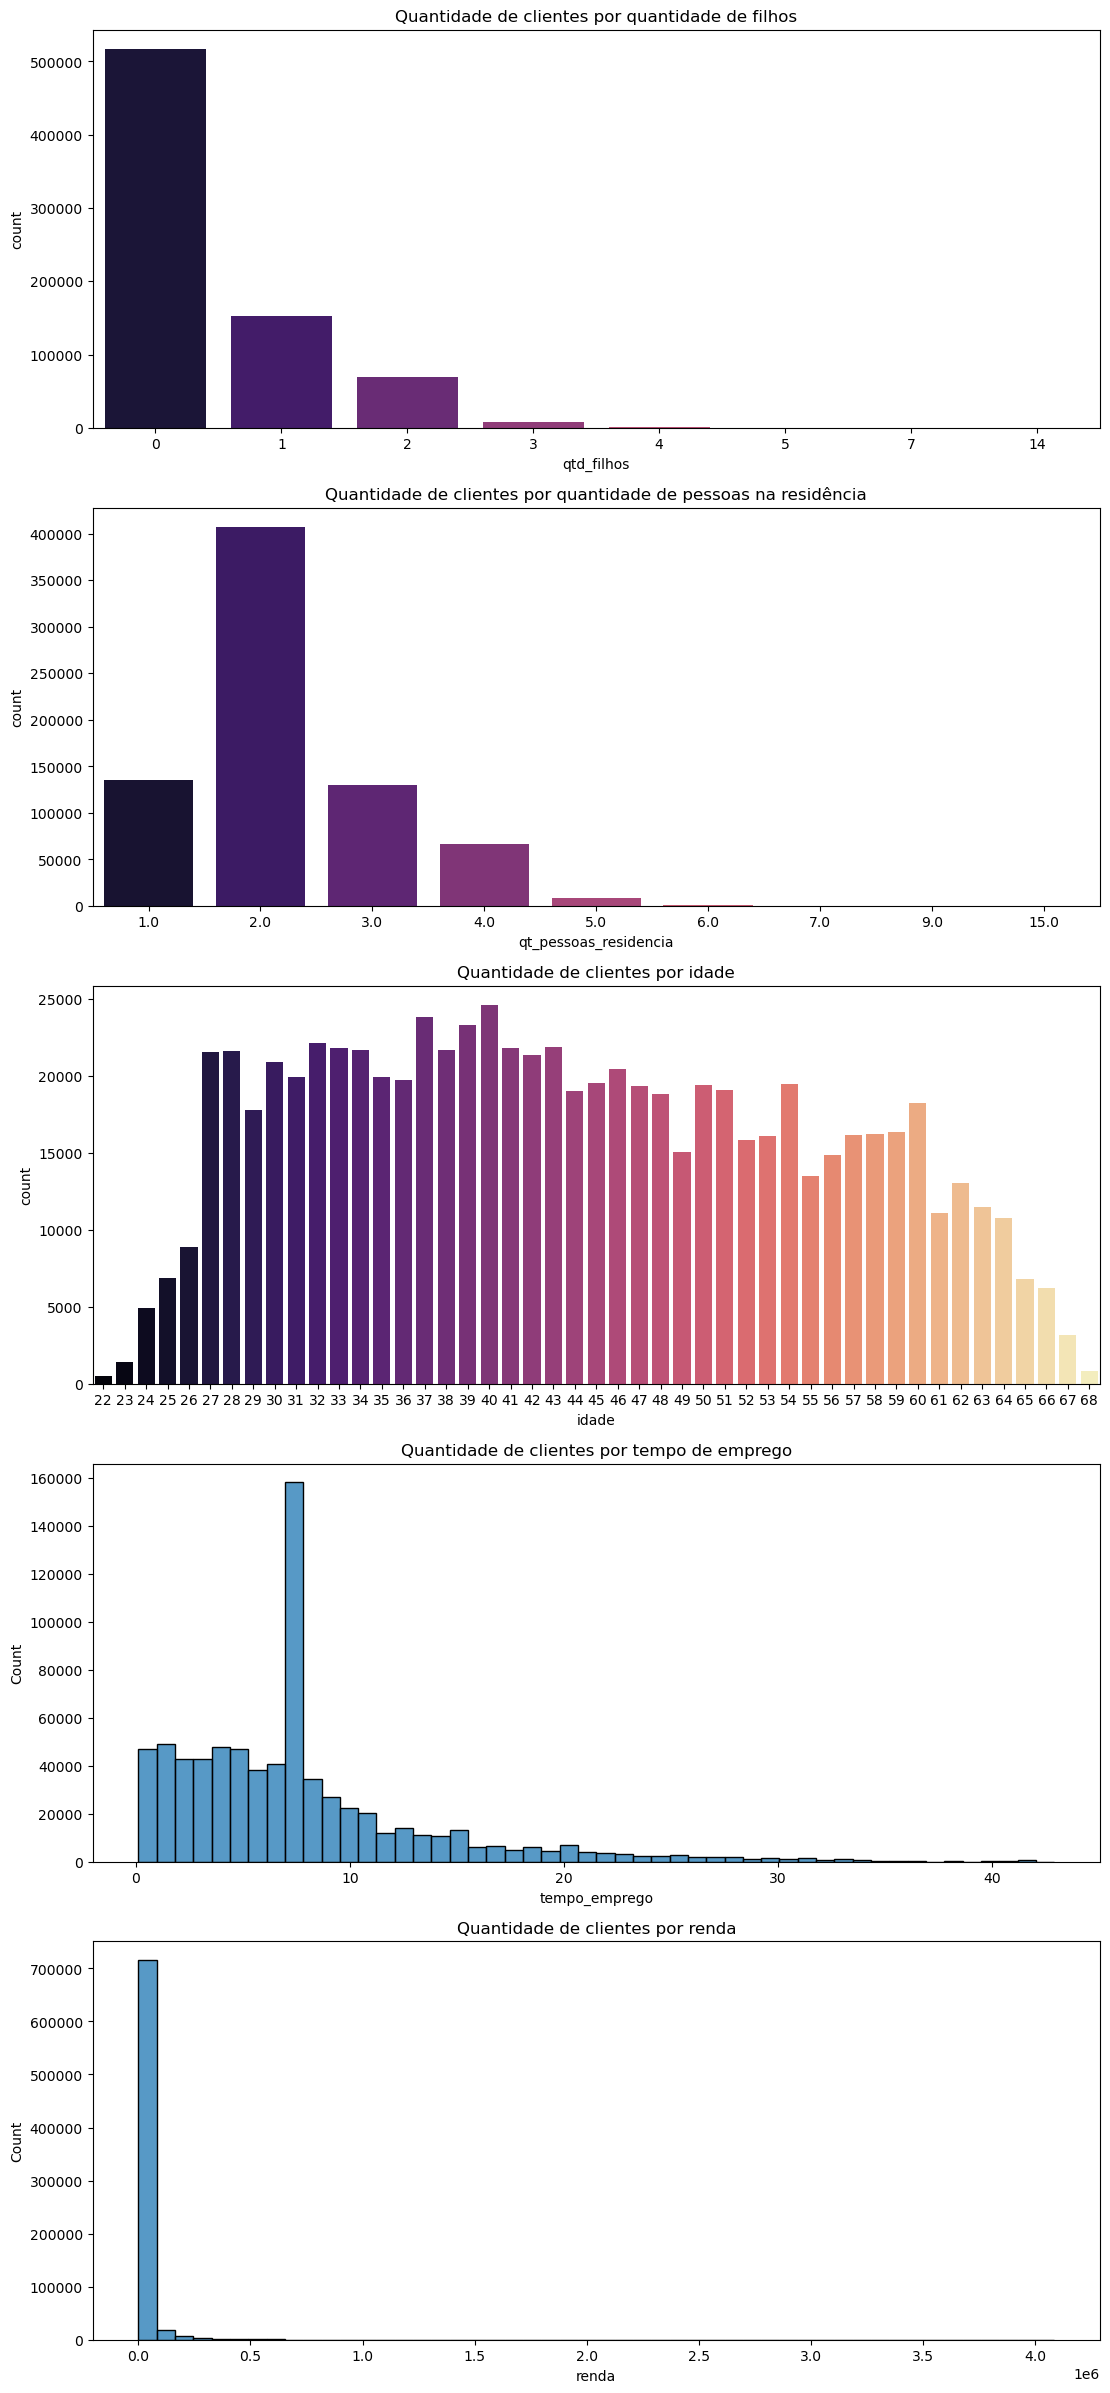

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(13, 30))

sns.countplot(data=df, x='qtd_filhos', palette='magma', ax=ax[0])
ax[0].set_title('Quantidade de clientes por quantidade de filhos')

sns.countplot(data=df, x='qt_pessoas_residencia', palette='magma', ax=ax[1])
ax[1].set_title('Quantidade de clientes por quantidade de pessoas na residência')

sns.countplot(data=df, x='idade', palette='magma', ax=ax[2])
ax[2].set_title('Quantidade de clientes por idade')

sns.histplot(data=df, x='tempo_emprego', bins=50, ax=ax[3])
ax[3].set_title('Quantidade de clientes por tempo de emprego')

sns.histplot(data=df, x='renda', bins=50, ax=ax[4])
ax[4].set_title('Quantidade de clientes por renda')

Text(0.5, 1.0, 'Quantidade de clientes por renda menor que R$50.000,00')

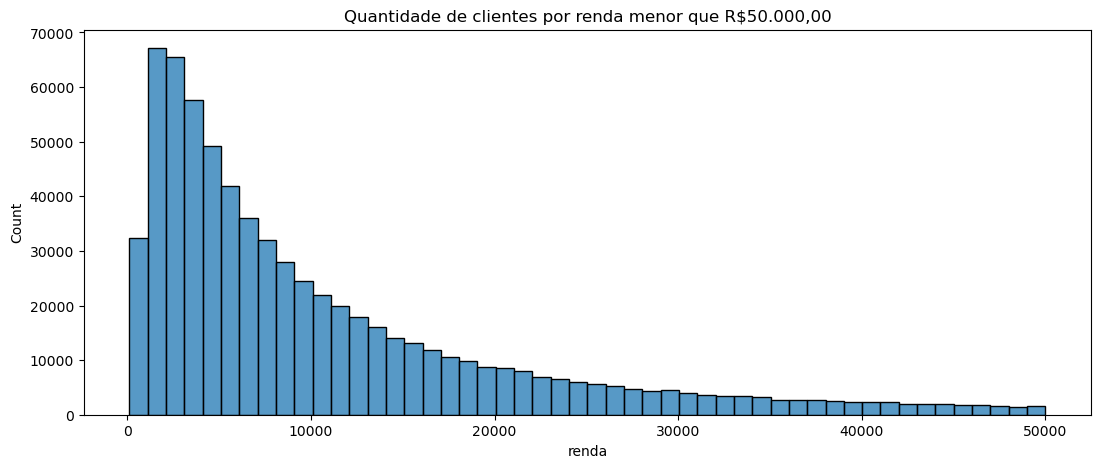

In [10]:
fig, ax = plt.subplots(figsize=(13,5))

sns.histplot(data=df[df.renda<50000], x='renda', bins=50, ax=ax)
ax.set_title('Quantidade de clientes por renda menor que R$50.000,00')

Text(0.5, 1.0, 'Quantidade de clientes por renda maior que R$50.000,00 reais')

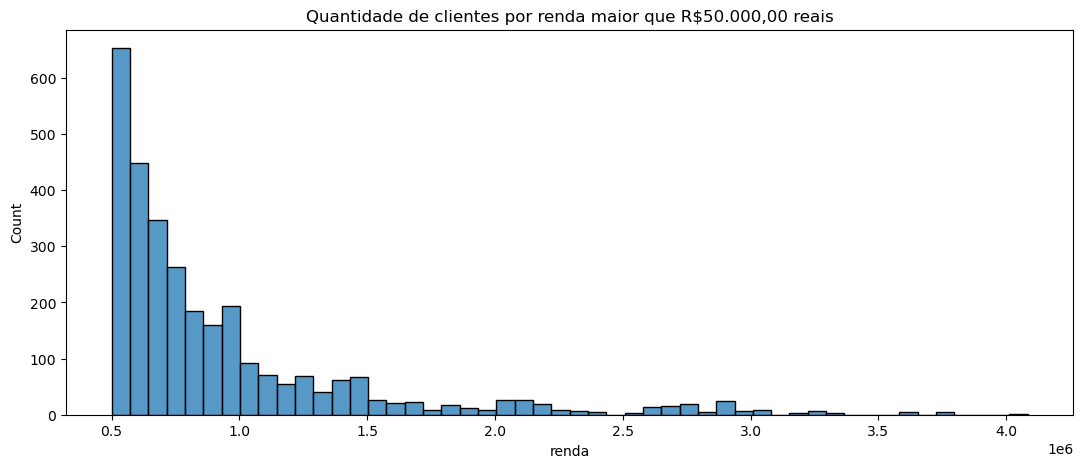

In [11]:
fig, ax = plt.subplots(figsize=(13,5))

sns.histplot(data=df[df.renda>500000], x='renda', bins=50, ax=ax)
ax.set_title('Quantidade de clientes por renda maior que R$50.000,00 reais')

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Text(0, 0.5, 'Proporção de inadimplentes')

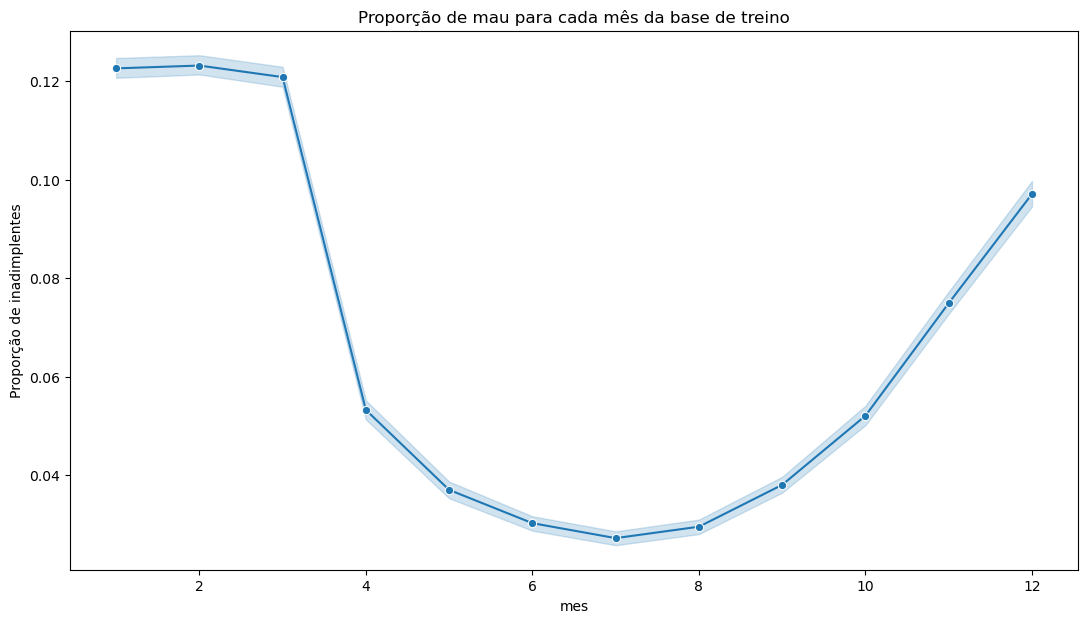

In [12]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(data=df, x='mes', y='mau', ax=ax, marker='o')
ax.set_title('Proporção de mau para cada mês da base de treino')
ax.set_ylabel("Proporção de inadimplentes")

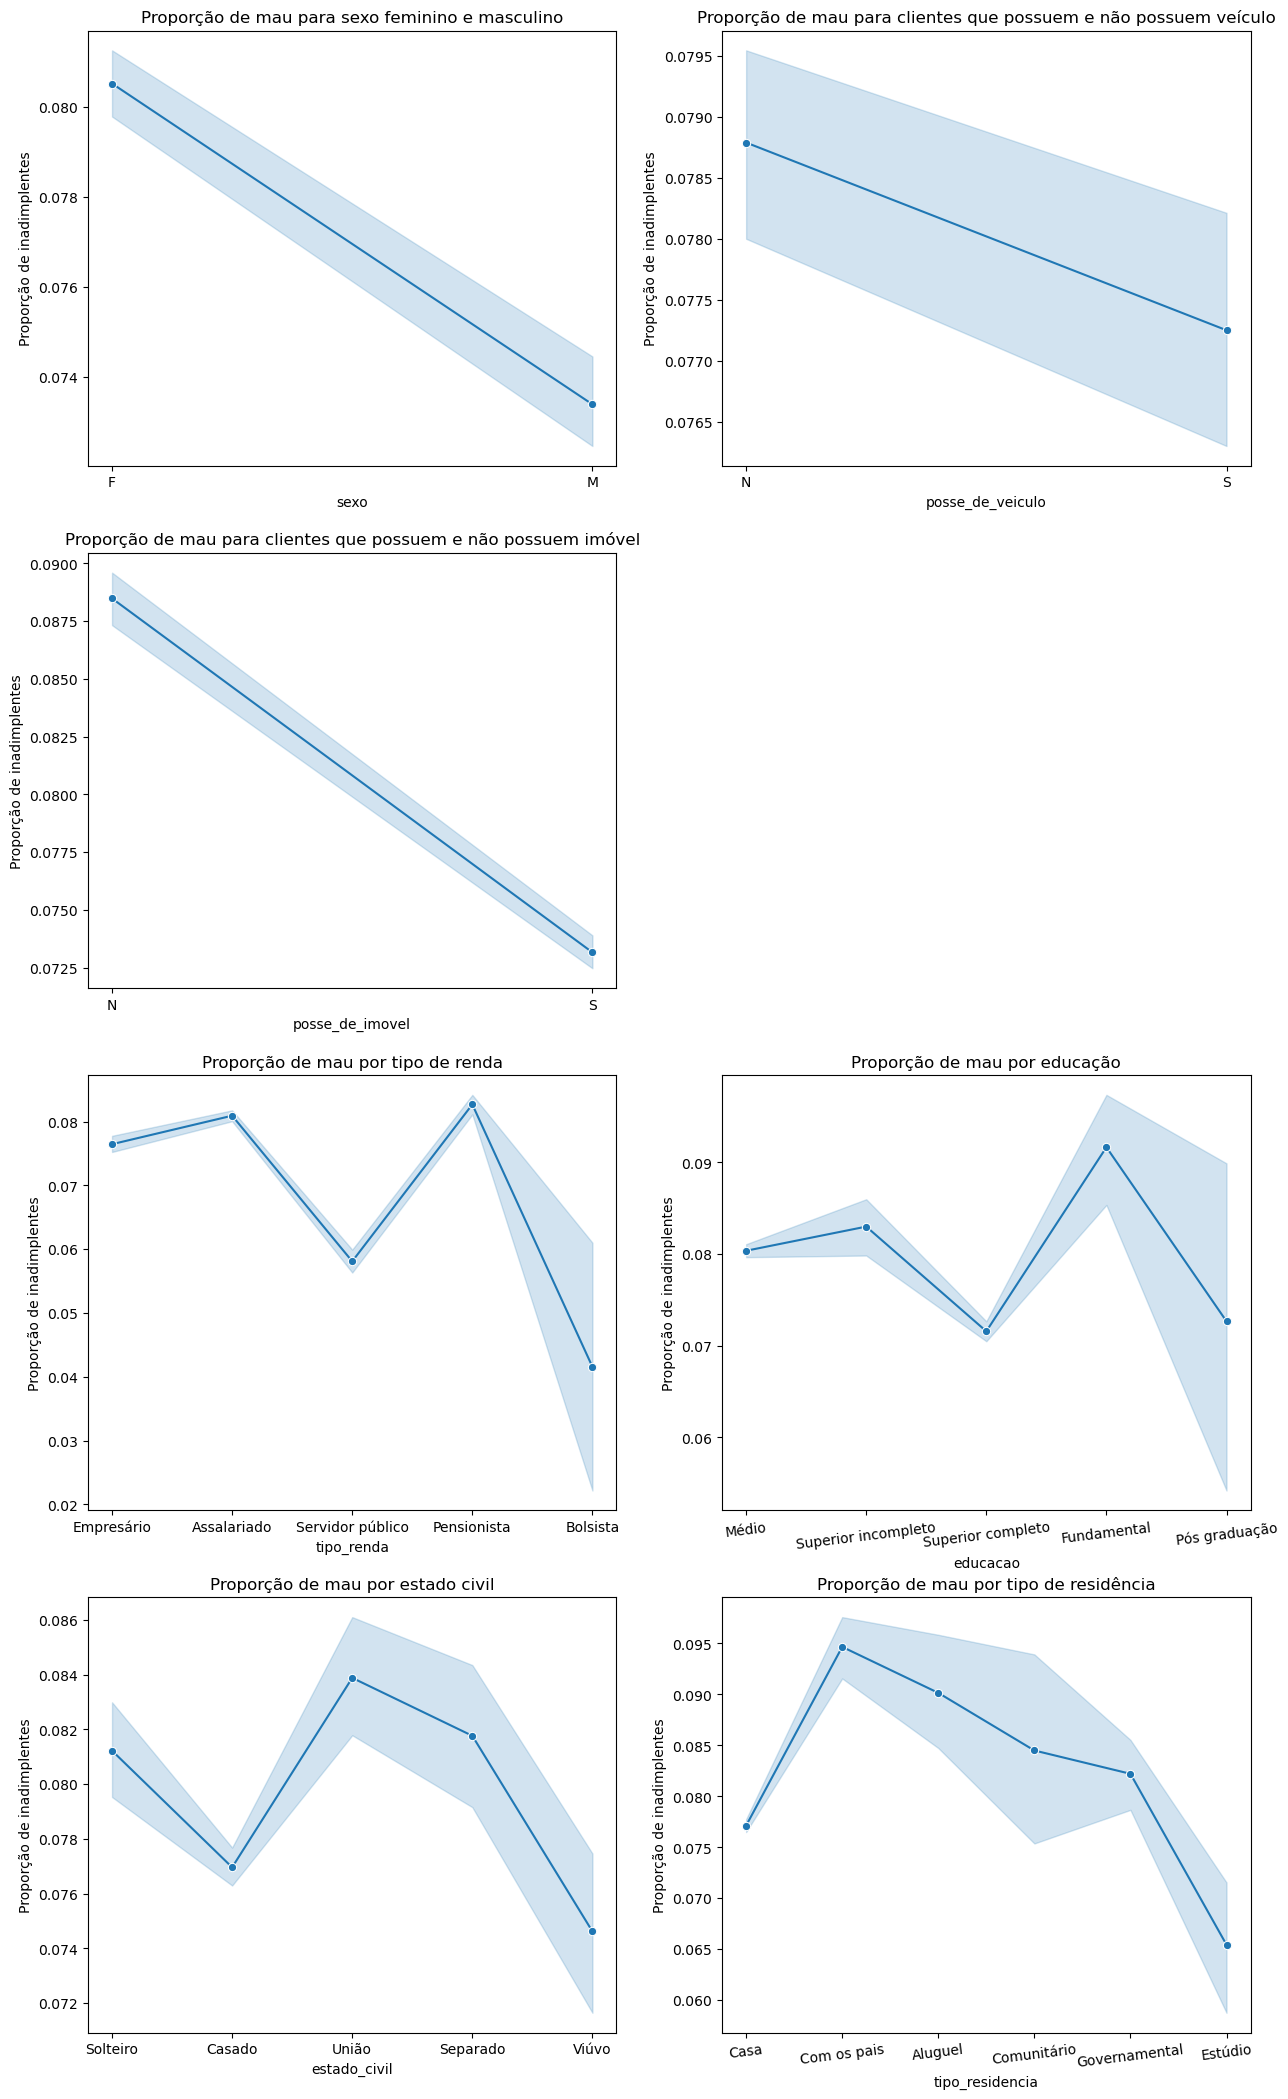

In [13]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 26))

sns.lineplot(data=df, x='sexo', y='mau', ax=ax[0, 0], marker='o')
ax[0, 0].set_title('Proporção de mau para sexo feminino e masculino')
ax[0, 0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df, x='posse_de_veiculo', y='mau', ax=ax[0, 1], marker='o')
ax[0, 1].set_title('Proporção de mau para clientes que possuem e não possuem veículo')
ax[0, 1].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df, x='posse_de_imovel', y='mau', ax=ax[1, 0], marker='o')
ax[1, 0].set_title('Proporção de mau para clientes que possuem e não possuem imóvel')
ax[1, 0].set_ylabel("Proporção de inadimplentes")

ax[1, 1].axis('off')

sns.lineplot(data=df, x='tipo_renda', y='mau', ax=ax[2, 0], marker='o')
ax[2, 0].set_title('Proporção de mau por tipo de renda')
ax[2, 0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df, x='educacao', y='mau', ax=ax[2, 1], marker='o')
ax[2, 1].set_title('Proporção de mau por educação')
ax[2, 1].set_ylabel("Proporção de inadimplentes")
for tick in ax[2, 1].get_xticklabels():
    tick.set_rotation(7)

sns.lineplot(data=df, x='estado_civil', y='mau', ax=ax[3, 0], marker='o')
ax[3, 0].set_title('Proporção de mau por estado civil')
ax[3, 0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df, x='tipo_residencia', y='mau', ax=ax[3, 1], marker='o')
ax[3, 1].set_title('Proporção de mau por tipo de residência')
ax[3, 1].set_ylabel("Proporção de inadimplentes")
for tick in ax[3, 1].get_xticklabels():
    tick.set_rotation(7)

Text(0, 0.5, 'Proporção de inadimplentes')

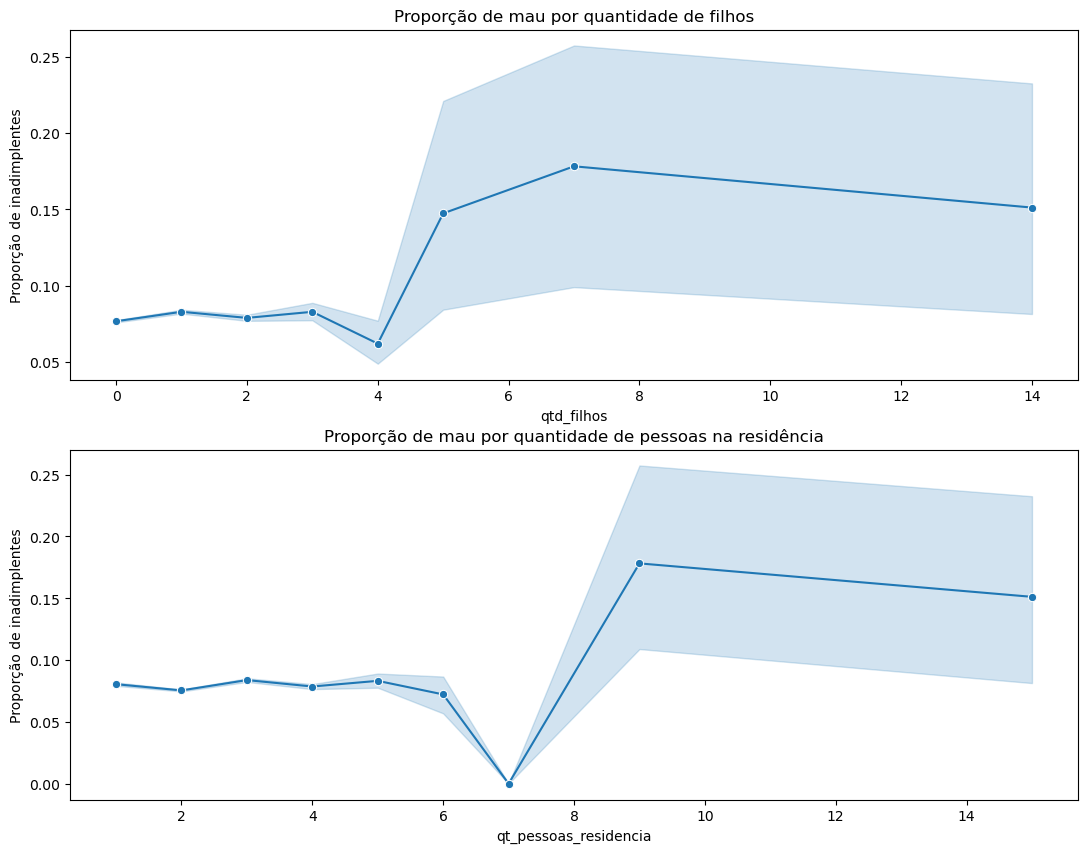

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 10))

sns.lineplot(data=df, x='qtd_filhos', y='mau', ax=ax[0], marker='o')
ax[0].set_title('Proporção de mau por quantidade de filhos')
ax[0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df, x='qt_pessoas_residencia', y='mau', ax=ax[1], marker='o')
ax[1].set_title('Proporção de mau por quantidade de pessoas na residência')
ax[1].set_ylabel("Proporção de inadimplentes")

Text(0.5, 1.0, 'Proporção de mau para intervalos de idade')

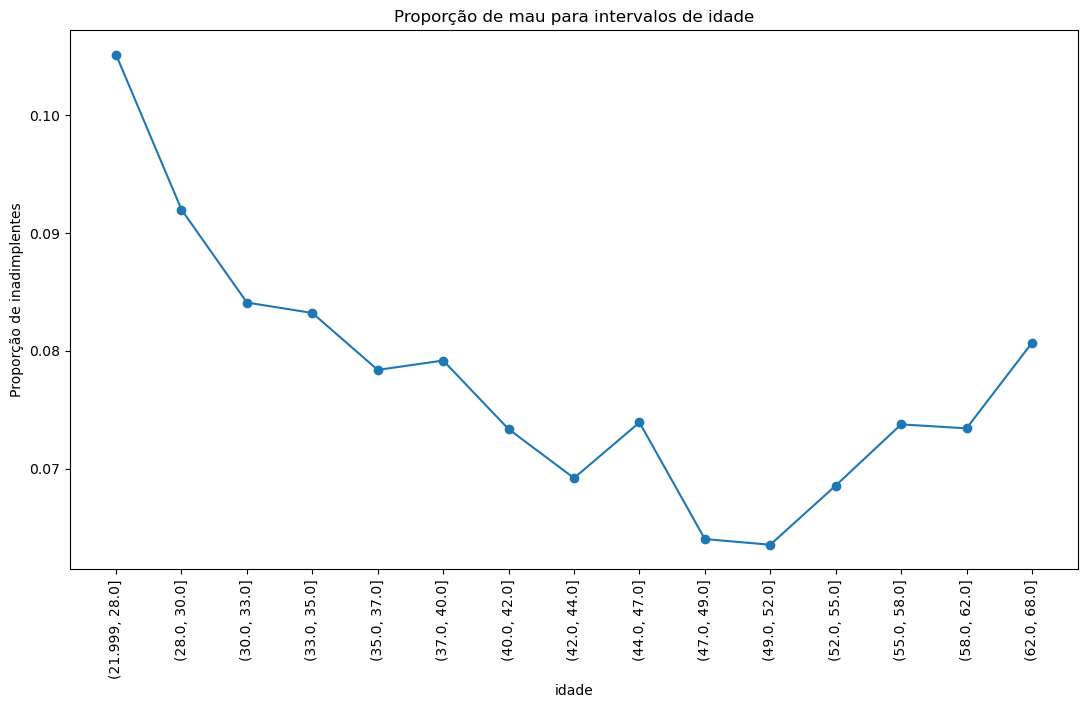

In [15]:
fig, ax = plt.subplots(figsize=(13, 7))

cat_1, bins = pd.qcut(df['idade'], 15, retbins=True)
df_1 = df.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Proporção de mau para intervalos de idade')

Text(0.5, 1.0, 'Proporção de mau para intervalos de tempo de emprego')

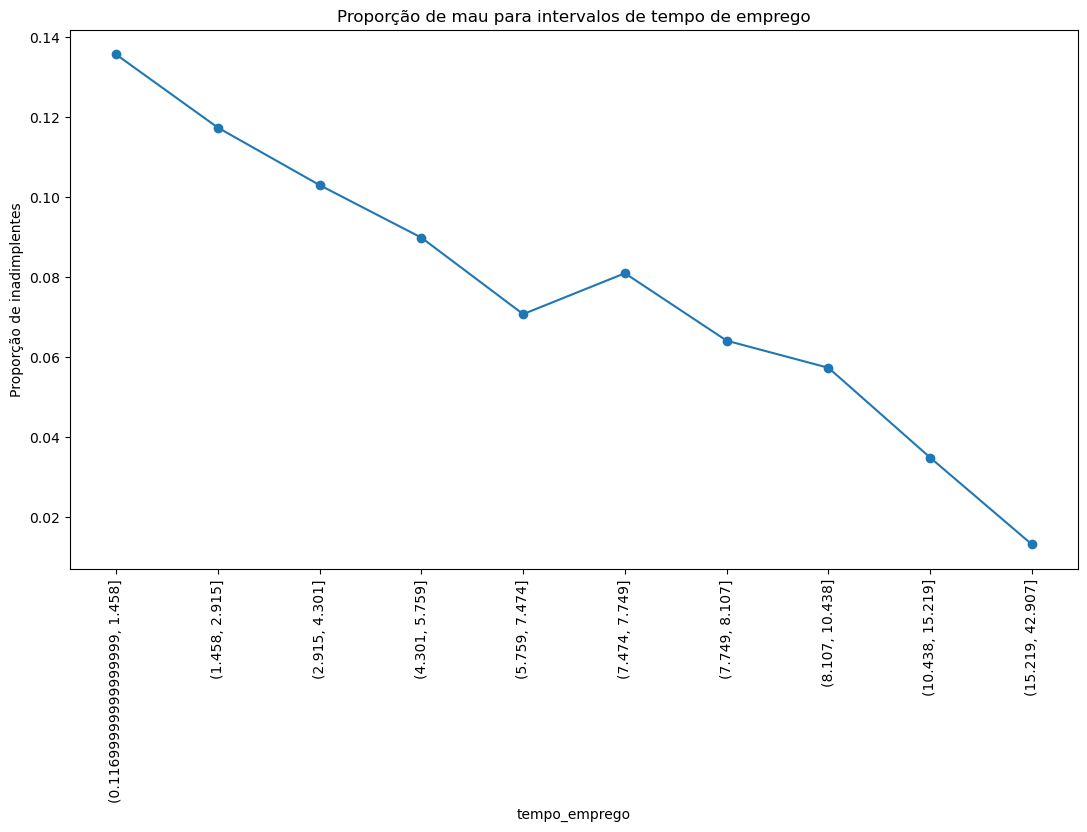

In [16]:
fig, ax = plt.subplots(figsize=(13, 7))

cat_1, bins = pd.qcut(df['tempo_emprego'], 10, retbins=True)
df_1 = df.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Proporção de mau para intervalos de tempo de emprego')

Text(0.5, 1.0, 'Proporção de mau para intervalos de renda')

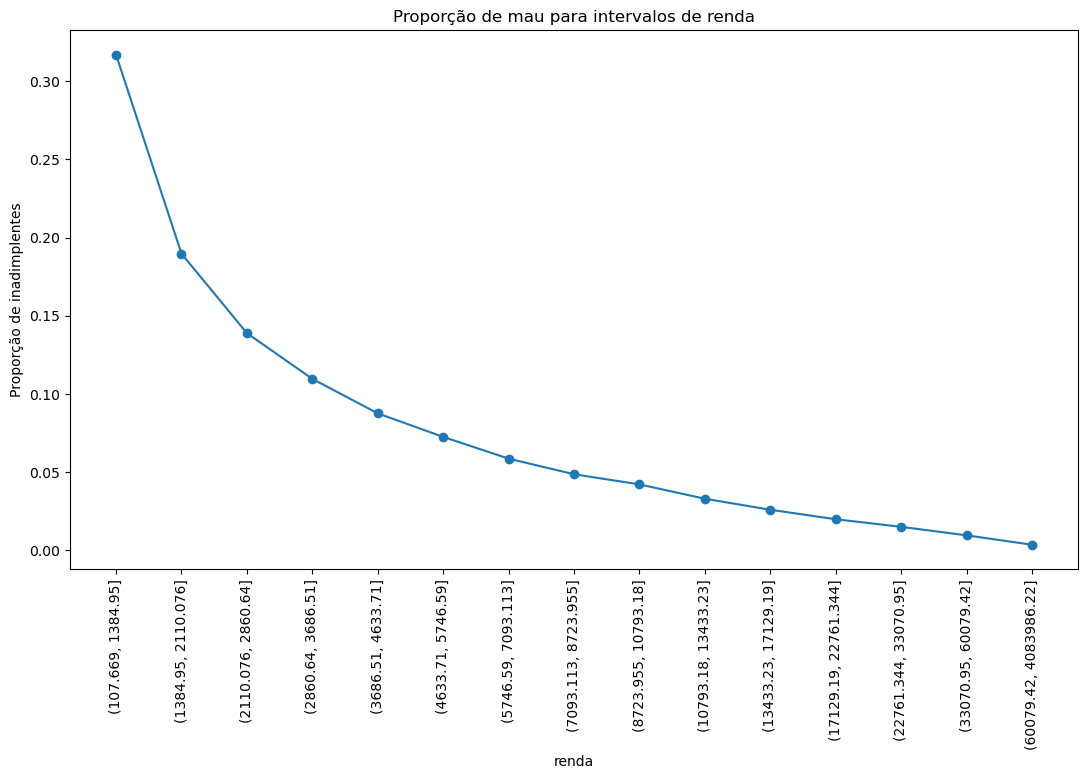

In [17]:
fig, ax = plt.subplots(figsize=(13, 7))

cat_1, bins = pd.qcut(df['renda'], 15, retbins=True)
df_1 = df.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Proporção de mau para intervalos de renda')

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [18]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    tilo_evento = tab.columns[0]
    tilo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[tilo_evento]/tab.loc['total', tilo_evento]
    tab['ep'] = tab[tilo_evento]/tab.loc['total', tilo_evento]

    tab['pct_nao_evento'] = tab[tilo_nao_evento] / tab.loc['total', tilo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [19]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau': g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont': g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=8)

    ax[1] = biv.cont.plot.bar()
    return biv

In [20]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau': g['mau'].mean(),
                        var: g[var].mean(),
                        'cont': g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    return None

In [21]:
df['mau'] = df.mau.astype('int64')
df.drop(columns=['data_ref', 'index', 'mes'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   750000 non-null  object 
 1   posse_de_veiculo       750000 non-null  object 
 2   posse_de_imovel        750000 non-null  object 
 3   qtd_filhos             750000 non-null  int64  
 4   tipo_renda             750000 non-null  object 
 5   educacao               750000 non-null  object 
 6   estado_civil           750000 non-null  object 
 7   tipo_residencia        750000 non-null  object 
 8   idade                  750000 non-null  int64  
 9   tempo_emprego          750000 non-null  float64
 10  qt_pessoas_residencia  750000 non-null  float64
 11  renda                  750000 non-null  float64
 12  mau                    750000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 74.4+ MB


In [22]:
# Metadados
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau', 'papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [23]:
for var in metadados[metadados.papel == 'covariavel'].index:
    if (metadados.loc[var, 'valores_unicos'] > 10):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var], 5, duplicates='drop'), df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002185
posse_de_veiculo,object,0,2,covariavel,0.000108
posse_de_imovel,object,0,2,covariavel,0.009693
qtd_filhos,int64,0,8,covariavel,0.001631
tipo_renda,object,0,5,covariavel,0.009360
educacao,object,0,5,covariavel,0.003547
estado_civil,object,0,5,covariavel,0.001126
tipo_residencia,object,0,6,covariavel,0.003045
idade,int64,0,47,covariavel,0.017968
tempo_emprego,float64,0,3005,covariavel,0.278819


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,463950,40630,0.080522,F,504580,0.000383,0.081273,0.079772,-2.435270,-2.425173,-2.445454,0.031918,0.042016,0.021734
M,227407,18013,0.073397,M,245420,0.000526,0.074428,0.072365,-2.535648,-2.520574,-2.550918,-0.068460,-0.053386,-0.083730


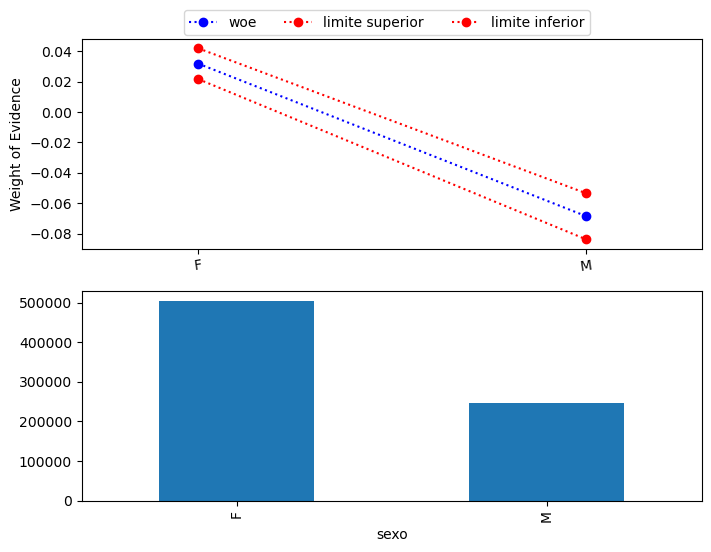

In [24]:
biv_discreta('sexo', df)

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,421872,36082,0.078790,N,457954,0.000398,0.07957,0.078009,-2.458908,-2.448206,-2.469707,0.008280,0.018982,-0.002519
S,269485,22561,0.077252,S,292046,0.000494,0.07822,0.076283,-2.480290,-2.466783,-2.493953,-0.013102,0.000405,-0.026765


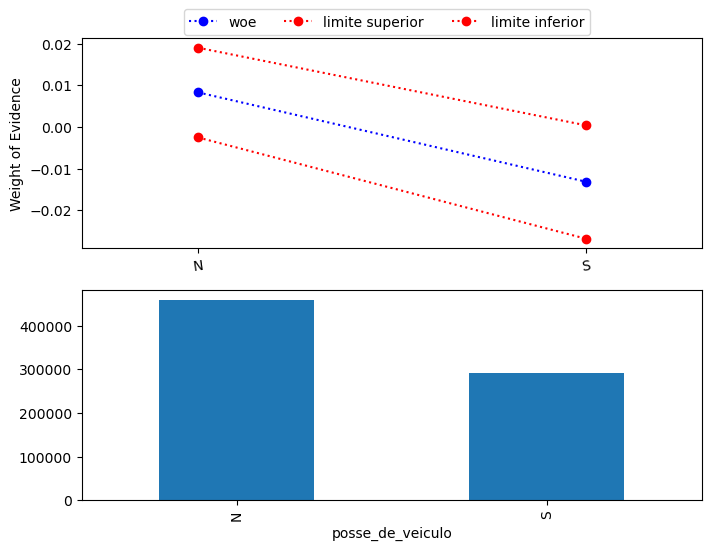

In [25]:
biv_discreta('posse_de_veiculo', df)

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,224515,21793,0.088479,N,246308,0.000572,0.089600,0.087357,-2.332354,-2.318526,-2.346340,0.134834,0.148662,0.120848
S,466842,36850,0.073160,S,503692,0.000367,0.073879,0.072441,-2.539135,-2.528578,-2.549789,-0.071947,-0.061389,-0.082601


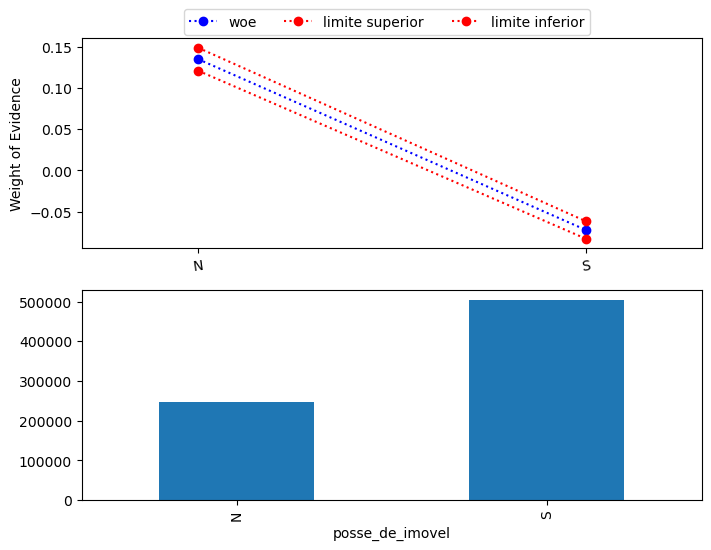

In [26]:
biv_discreta('posse_de_imovel', df)

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,477683,39648,0.076640,0,517331,0.000370,0.077364,0.075915,-2.488907,-2.478707,-2.499195,-0.021719,-0.011519,-0.032007
1,140345,12676,0.082838,1,153021,0.000705,0.084219,0.081457,-2.404393,-2.386352,-2.422710,0.062795,0.080836,0.044478
2,64142,5490,0.078843,2,69632,0.001021,0.080845,0.076841,-2.458171,-2.430924,-2.486058,0.009017,0.036264,-0.018870
3,7951,718,0.082824,3,8669,0.002960,0.088627,0.077021,-2.404583,-2.330522,-2.483526,0.062605,0.136667,-0.016338
4,999,66,0.061972,4,1065,0.007388,0.076469,0.047475,-2.717100,-2.491324,-2.998913,-0.249912,-0.024136,-0.531725
5,81,14,0.147368,5,95,0.036368,0.219578,0.075159,-1.755392,-1.268126,-2.510021,0.711796,1.199062,-0.042833
7,83,18,0.178218,7,101,0.038080,0.253767,0.102669,-1.528469,-1.078622,-2.167916,0.938719,1.388566,0.299272
14,73,13,0.151163,14,86,0.038627,0.227963,0.074363,-1.725510,-1.219851,-2.521524,0.741678,1.247337,-0.054336


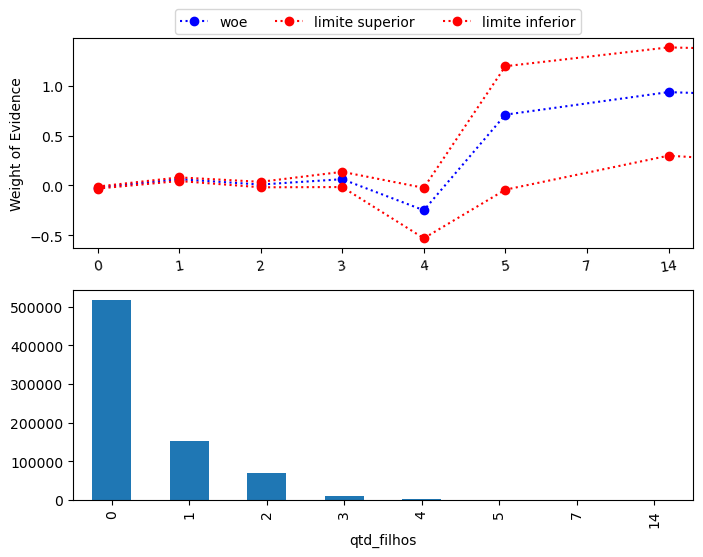

In [27]:
biv_discreta('qtd_filhos', df)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,354527,31213,0.080917,Assalariado,385740,0.000439,0.081778,0.080057,-2.429950,-2.418434,-2.441578,0.037238,0.048754,0.025610
Bolsista,346,15,0.041551,Bolsista,361,0.010503,0.062207,0.020896,-3.138389,-2.713068,-3.847087,-0.671200,-0.245880,-1.379899
Empresário,159508,13204,0.076451,Empresário,172712,0.000639,0.077704,0.075198,-2.491574,-2.473957,-2.509458,-0.024386,-0.006769,-0.042270
Pensionista,115825,10440,0.082683,Pensionista,126265,0.000775,0.084202,0.081164,-2.406436,-2.386573,-2.426634,0.060752,0.080615,0.040555
Servidor público,61151,3771,0.058085,Servidor público,64922,0.000918,0.059884,0.056286,-2.786006,-2.753587,-2.819381,-0.318818,-0.286399,-0.352193


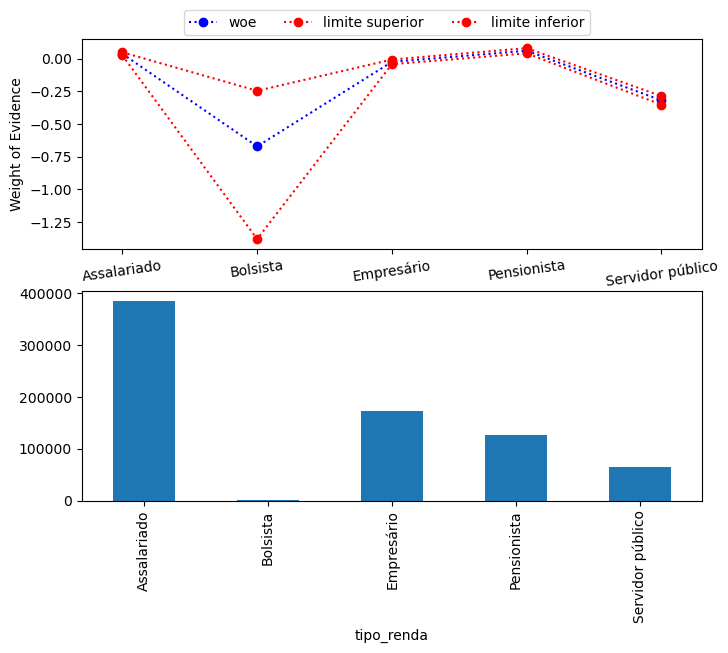

In [28]:
biv_discreta('tipo_renda', df)

0.009177210501933833

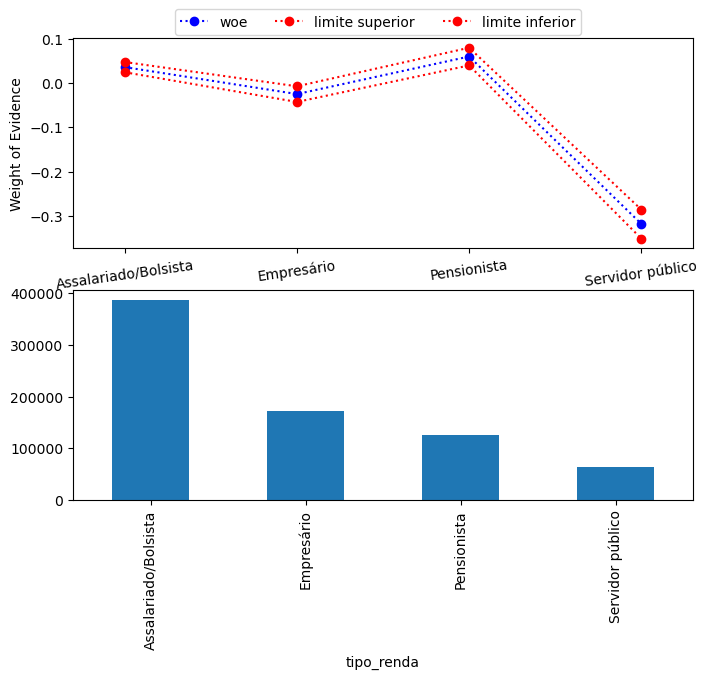

In [29]:
# Agrupando as classes da variável educacao

df.tipo_renda.replace(
    {'Assalariado': 'Assalariado/Bolsista',
     'Bolsista': 'Assalariado/Bolsista'}, inplace=True)

biv_discreta('tipo_renda', df)
IV(df.tipo_renda, df.mau)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,7789,786,0.091662,Fundamental,8575,0.003116,0.097770,0.085554,-2.293511,-2.222252,-2.369175,0.173677,0.244936,0.098013
Médio,466106,40730,0.080361,Médio,506836,0.000382,0.081110,0.079613,-2.437448,-2.427364,-2.447619,0.029740,0.039824,0.019570
Pós graduação,753,59,0.072660,Pós graduação,812,0.009109,0.090541,0.054779,-2.546528,-2.307049,-2.848105,-0.079340,0.160139,-0.380917
Superior completo,189684,14622,0.071569,Superior completo,204306,0.000570,0.072687,0.070451,-2.562832,-2.546130,-2.579777,-0.095644,-0.078942,-0.112588
Superior incompleto,27025,2446,0.082997,Superior incompleto,29471,0.001607,0.086147,0.079847,-2.402308,-2.361619,-2.444427,0.064880,0.105569,0.022761


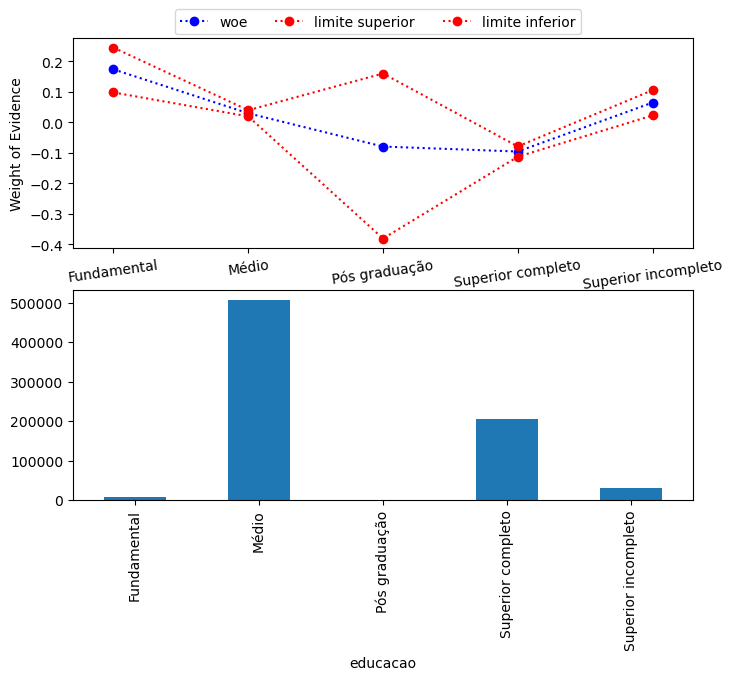

In [30]:
biv_discreta('educacao', df)

0.0032552444112051294

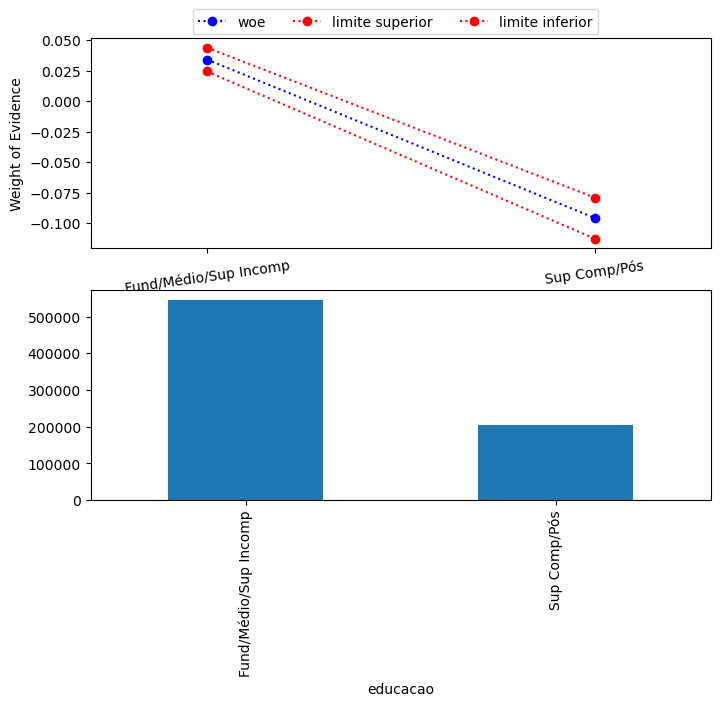

In [31]:
# Agrupando as classes da variável educacao

df.educacao.replace(
    {'Fundamental': 'Fund/Médio/Sup Incomp',
     'Médio': 'Fund/Médio/Sup Incomp',
     'Superior incompleto': 'Fund/Médio/Sup Incomp',
     'Superior completo': 'Sup Comp/Pós',
     'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

biv_discreta('educacao', df)
IV(df.educacao, df.mau)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,485953,40519,0.076963,Casado,526472,0.000367,0.077683,0.076243,-2.484341,-2.474249,-2.494519,-0.017153,-0.007061,-0.027331
Separado,39090,3481,0.081769,Separado,42571,0.001328,0.084372,0.079166,-2.418547,-2.384371,-2.453729,0.048641,0.082817,0.013459
Solteiro,84214,7445,0.081225,Solteiro,91659,0.000902,0.082994,0.079456,-2.425819,-2.402352,-2.449755,0.041370,0.064836,0.017433
União,52846,4839,0.083887,União,57685,0.001154,0.086149,0.081624,-2.390674,-2.361590,-2.420479,0.076514,0.105598,0.046709
Viúvo,29254,2359,0.074621,Viúvo,31613,0.001478,0.077518,0.071724,-2.517779,-2.476557,-2.560498,-0.050590,-0.009369,-0.093310


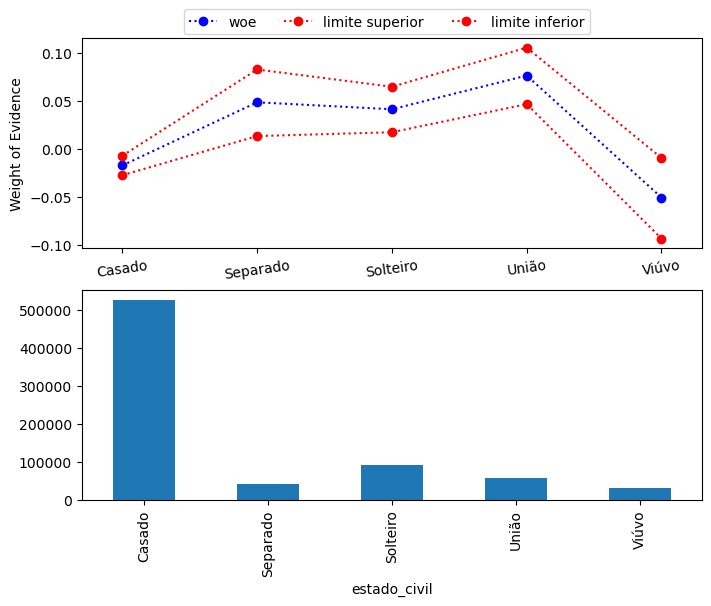

In [32]:
biv_discreta('estado_civil', df)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,9416,933,0.090154,Aluguel,10349,0.002815,0.095672,0.084635,-2.311760,-2.246264,-2.380974,0.155428,0.220924,0.086214
Casa,622288,52006,0.077127,Casa,674294,0.000325,0.077763,0.076490,-2.482044,-2.473131,-2.491024,-0.014856,-0.005943,-0.023836
Com os pais,30086,3146,0.094668,Com os pais,33232,0.001606,0.097815,0.091520,-2.257928,-2.221736,-2.295214,0.209260,0.245452,0.171974
Comunitário,3012,278,0.084498,Comunitário,3290,0.004849,0.094006,0.074991,-2.382738,-2.265675,-2.512435,0.084450,0.201513,-0.045247
Estúdio,5042,353,0.065431,Estúdio,5395,0.003367,0.072031,0.058831,-2.659090,-2.555902,-2.772455,-0.191902,-0.088714,-0.305267
Governamental,21513,1927,0.082210,Governamental,23440,0.001794,0.085727,0.078693,-2.412693,-2.366968,-2.460235,0.054495,0.100221,0.006953


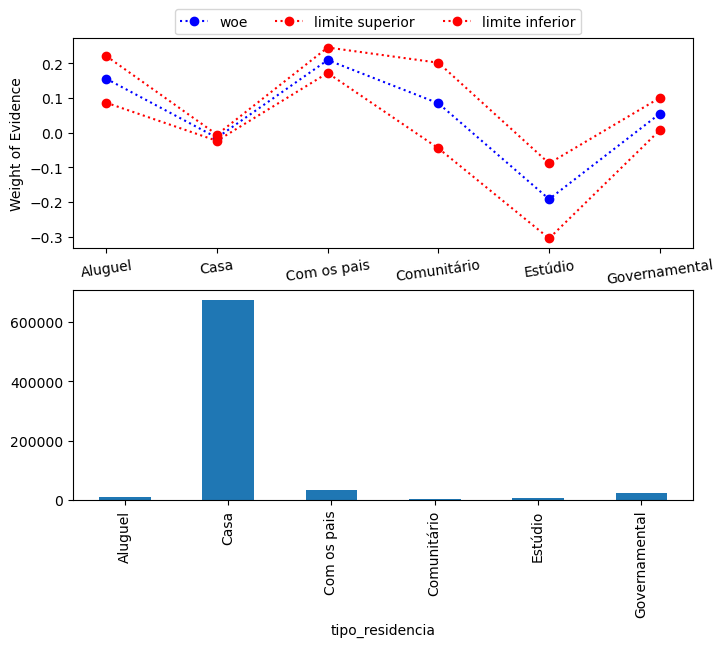

In [33]:
biv_discreta('tipo_residencia', df)

C:\Users\Artur\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Artur\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Artur\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,124842,10926,0.080476,1.0,135768,0.000738,0.081923,0.079029,-2.435904,-2.416508,-2.455620,0.031284,0.050680,0.011568
2.0,377007,30769,0.075456,2.0,407776,0.000414,0.076266,0.074645,-2.505756,-2.494192,-2.517434,-0.038568,-0.027004,-0.050246
3.0,119168,10900,0.083802,3.0,130068,0.000768,0.085308,0.082296,-2.391771,-2.372317,-2.411547,0.075417,0.094871,0.055642
4.0,61511,5248,0.078611,4.0,66759,0.001042,0.080653,0.076570,-2.461369,-2.433512,-2.489896,0.005819,0.033676,-0.022708
5.0,7593,689,0.083192,5.0,8282,0.003035,0.089141,0.077244,-2.399741,-2.324166,-2.480399,0.067447,0.143022,-0.013211
6.0,1028,80,0.072202,6.0,1108,0.007776,0.087459,0.056946,-2.553344,-2.345067,-2.807026,-0.086156,0.122121,-0.339838
7.0,52,0,0.000000,7.0,52,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,83,18,0.178218,9.0,101,0.038080,0.253767,0.102669,-1.528469,-1.078622,-2.167916,0.938719,1.388566,0.299272
15.0,73,13,0.151163,15.0,86,0.038627,0.227963,0.074363,-1.725510,-1.219851,-2.521524,0.741678,1.247337,-0.054336


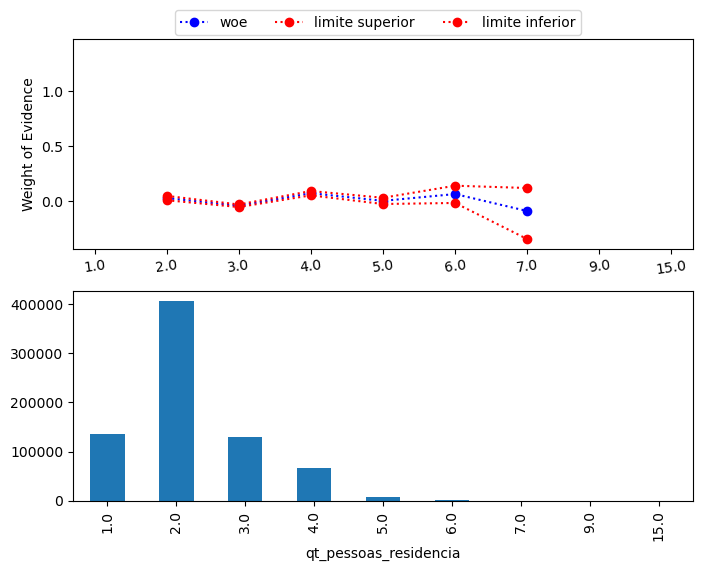

In [34]:
biv_discreta('qt_pessoas_residencia', df)

Existem zeros estruturais na variável qtd_pessoas_residencia. Utilizando a informação presente no gráfico bivariado da variável mau podemos perceber que a proporção de indadimplentes não aumenta ou diminui proporcionalmente com a variável qtd_pessoas_residencia, portanto, os zeros serão removidos.

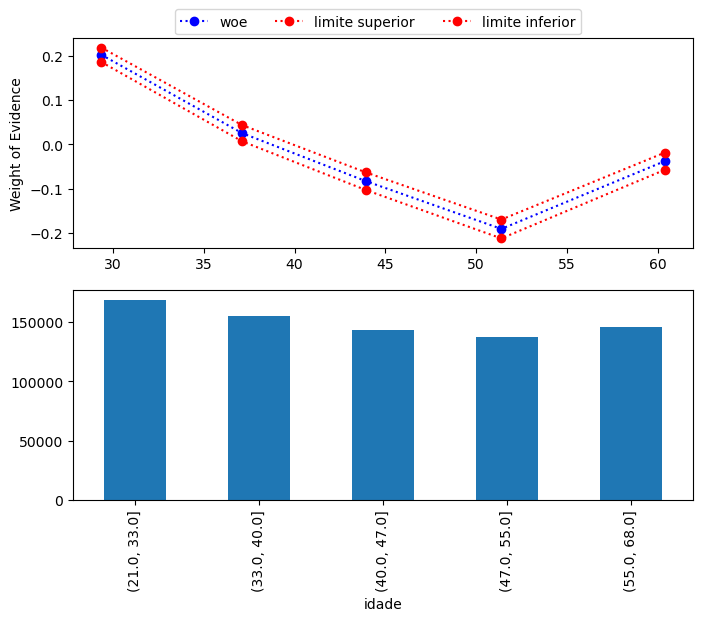

In [35]:
biv_continua('idade', 5, df)

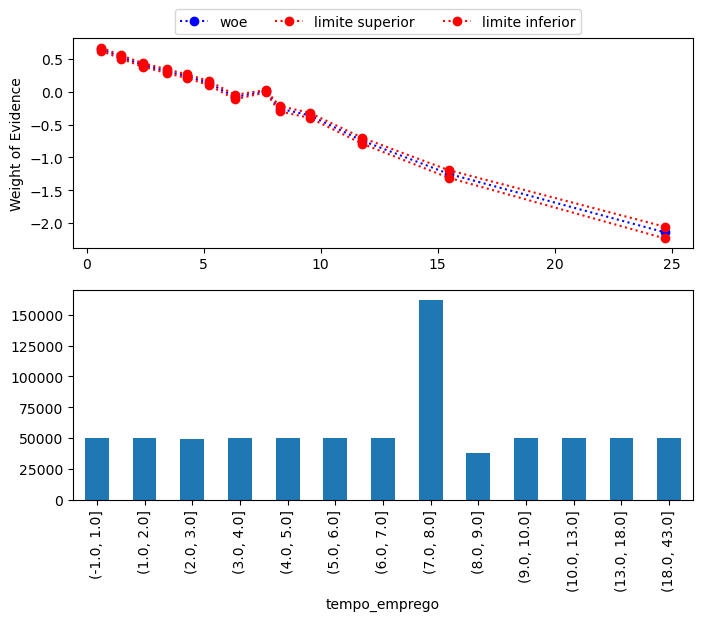

In [36]:
biv_continua('tempo_emprego', 15, df)

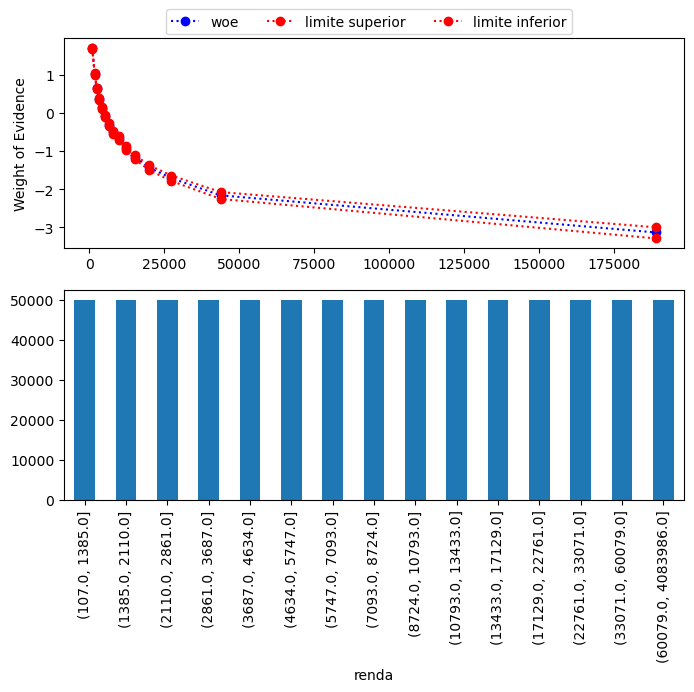

In [37]:
biv_continua('renda', 15, df)

## Criando o modelo

In [38]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'qt_pessoas_residencia + renda + tempo_emprego + idade + posse_de_imovel + tipo_renda + educacao + tipo_residencia + sexo + qtd_filhos + estado_civil + posse_de_veiculo + mau'

In [47]:
formula = '''
     mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego + renda
'''

log_reg = smf.glm(formula, data=X_train, family=sm.families.Binomial()).fit()

log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599975
Model Family:                         Binomial   Df Model:                           24
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2483e+05
Date:                         Thu, 26 Oct 2023   Deviance:                   2.4966e+05
Time:                                 15:58:51   Pearson chi2:                 1.61e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.04277
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.3770      0.072     19.221      0.000       1.237       1.517
sexo[T.M]                            0.1261      0.013      9.604      0.000       0.100       0.152
posse_de_veiculo[T.S]               -0.0318      0.012     -2.572      0.010      -0.056      -0.008
posse_de_imovel[T.S]                 0.0858      0.012      7.260      0.000       0.063       0.109
tipo_renda[T.Bolsista]              -0.1252      0.300     -0.417      0.677      -0.713       0.463
tipo_renda[T.Empresário]             0.0530      0.014      3.783      0.000       0.026       0.080
tipo_renda[T.Pensionista]            0.0398      0.020      1.963      0.050     5.4e-05       0.080
tipo_renda[T.Servidor público]       0.0320      0.023      1.378      0.168      -0.014       0.078
educacao[T.Médio]                    0.0305      0.049      0.625      0.532      -0.065       0.126
educacao[T.Pós graduação]            0.0460      0.168      0.274      0.784      -0.283       0.375
educacao[T.Superior completo]        0.0907      0.050      1.823      0.068      -0.007       0.188
educacao[T.Superior incompleto]      0.0804      0.056      1.443      0.149      -0.029       0.190
estado_civil[T.Separado]            -0.0380      0.024     -1.598      0.110      -0.085       0.009
estado_civil[T.Solteiro]            -0.0067      0.017     -0.388      0.698      -0.041       0.027
estado_civil[T.União]               -0.0476      0.020     -2.339      0.019      -0.087      -0.008
estado_civil[T.Viúvo]                0.0335      0.029      1.154      0.248      -0.023       0.090
tipo_residencia[T.Casa]              0.0891      0.044      2.023      0.043       0.003       0.175
tipo_residencia[T.Com os pais]       0.0743      0.050      1.500      0.134      -0.023       0.171
tipo_residencia[T.Comunitário]       0.1402      0.089      1.568      0.117      -0.035       0.315
tipo_residencia[T.Estúdio]           0.0337      0.082      0.409      0.683      -0.128       0.195
tipo_residencia[T.Governamental]     0.0865      0.053      1.622      0.105      -0.018       0.191
qtd_filhos                          -0.0034      0.008     -0.428      0.669      -0.019       0.012
idade                            -9.025e-05      0.001     -0.129      0.898      -0.001       0.001
tempo_emprego                        0.0237      0.002     13.122      0.000       0.020       0.027
renda                                0.0001   1.09e-06     93.645      0.000    9.95e-05       0.000
====================================================================================================
"""

In [56]:
# Tranformando a variável renda
formula = '''
    mau ~ np.log(renda)
'''

log_reg = smf.glm(formula, data=X_train, family=sm.families.Binomial()).fit()

log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599998
Model Family:                         Binomial   Df Model:                            1
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2028e+05
Date:                         Thu, 26 Oct 2023   Deviance:                   2.4055e+05
Time:                                 16:03:41   Pearson chi2:                 5.97e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.05719
Covariance Type:                     nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.9239      0.049   -121.382      0.000      -6.020      -5.828
np.log(renda)     0.9908      0.006    169.858      0.000       0.979       1.002
=================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [51]:
X_train['score'] = log_reg.predict(X_train)

# Acurácia
acc = metrics.accuracy_score(X_train.mau, X_train.score > .018)

# AUC
fpr, tpr, thresholds = metrics.roc_curve(X_train.mau, X_train.score)
auc = metrics.auc(fpr, tpr)

# Gini
gini = 2*auc - 1
ks = ks_2samp(X_train.loc[X_train.mau == 1, 'score'],
              X_train.loc[X_train.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'.format(acc, auc, gini, ks))

Acurácia: 6.1% 
AUC: 23.4% 
GINI: -53.1%
KS: 39.4%


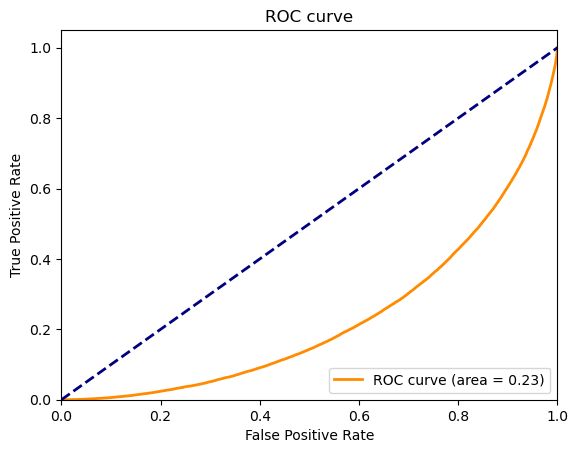

In [42]:
fpr, tpr, thresholds = metrics.roc_curve(X_train['mau'], X_train['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(X_train['mau'], X_train['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

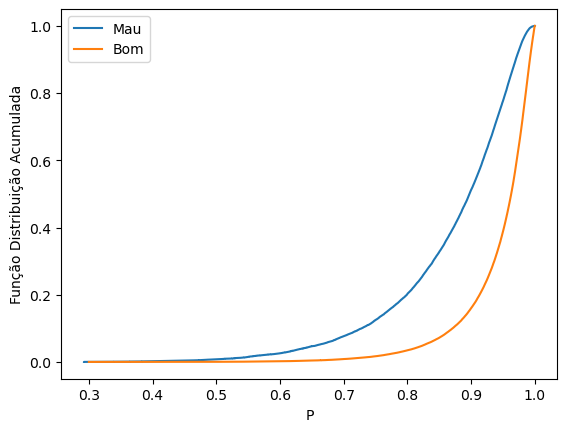

In [43]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = X_train.loc[X_train['mau'] == 1, 'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

score_pop2 = X_train.loc[X_train['mau'] != 1, 'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

Temos uma métrica de precisão satisfatória e a curva ROC apresentou uma área acima de 0.5, o que é um bom indicativo, embora uma pontuação próxima de 0.75 seja considerada apenas mediana. O gráfico da função de distribuição acumulada não alcançou um desempenho excepcional, no entanto, um valor KS de quase 40% ainda é considerado aceitável.

## Base de teste out of Time

In [44]:
y_test.educacao.replace(
    {'Fundamental': 'Fund/Médio/Sup Incomp',
     'Médio': 'Fund/Médio/Sup Incomp',
     'Superior incompleto': 'Fund/Médio/Sup Incomp',
     'Superior completo': 'Sup Comp/Pós',
     'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

y_test['score'] = log_reg.predict(y_test)

# Acurácia
acc = metrics.accuracy_score(y_test.mau, y_test.score > .068)

# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test.mau, y_test.score)
auc = metrics.auc(fpr, tpr)

# Gini
gini = 2*auc - 1
ks = ks_2samp(y_test.loc[y_test.mau == 1, 'score'],
              y_test.loc[y_test.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'.format(acc, auc, gini, ks))

Acurácia: 14.7% 
AUC: 26.1% 
GINI: -47.8%
KS: 34.7%


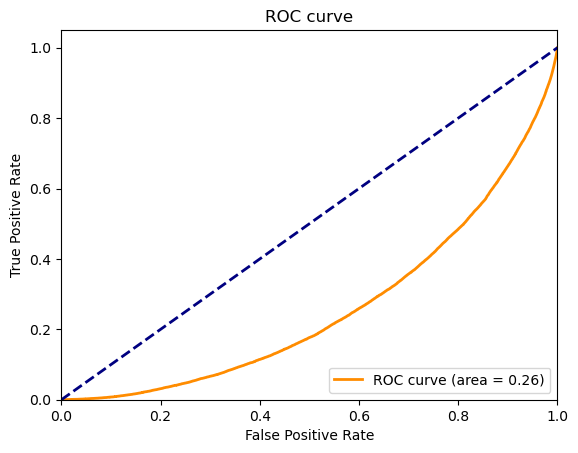

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(y_test['mau'], y_test['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(y_test['mau'], y_test['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

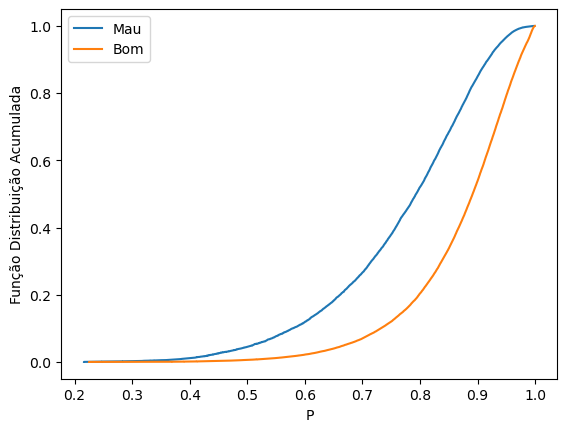

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = y_test.loc[y_test['mau'] == 1, 'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

score_pop2 = y_test.loc[y_test['mau'] != 1, 'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

Embora tenhamos observado uma redução significativa na precisão do modelo ao avaliá-lo com a base de testes, os indicadores AUC, GINI e KS não sofreram mudanças significativas. Isso indica que o modelo continua sendo bastante consistente e confiável.